# Virtual data set (VDS) reference file for SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6 using Virtualizarr


In [7]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [8]:
# Get Earthdata creds
earthaccess.login()

In [9]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [4]:
# Locate CCMP file information / metadata:
shortname = "SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6"
granule_info = earthaccess.search_data(
    short_name=shortname,
    )

In [10]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:5]

Number of granules found = 3676
First few granules:


['s3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2015_091_FNL_v06.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2015_092_FNL_v06.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2015_093_FNL_v06.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2015_094_FNL_v06.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2015_095_FNL_v06.0.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [21]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["time", "lat", "lon", "iceflag_components", "uncertainty_components"]

In [22]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [23]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [14]:
# Start up cluster and print some information about it:
client = Client(n_workers=30, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

/opt/coiled/env/lib/python3.13/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36443 instead
  warnings.warn(


LocalCluster(1733d69d, 'tcp://127.0.0.1:42697', workers=30, threads=30, memory=122.29 GiB)
View any work being done on the cluster here https://cluster-ievfi.dask.host/jupyter/proxy/36443/status


In [24]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 1min 59s, sys: 24.8 s, total: 2min 24s
Wall time: 5min 58s


In [25]:
len(virtual_ds_list)

3676

## 3. Generate combined reference file

In [26]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 13.3 s, sys: 267 ms, total: 13.6 s
Wall time: 13.1 s


In [27]:
# Save in JSON or PARQUET format:
fname_combined_json = shortname + "_virtual_s3" + ".json"
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')

## 4. Test combined reference files

In [28]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### 4.1 JSON reference file

In [29]:
%%time
data = opends_withref(fname_combined_json, fs)
data

CPU times: user 31.2 ms, sys: 2.9 ms, total: 34.1 ms
Wall time: 32.1 ms


<xarray.Dataset> Size: 1TB
Dimensions:                 (time: 3676, lat: 720, lon: 1440,
                             iceflag_components: 3, uncertainty_components: 9)
Coordinates:
  * lat                     (lat) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * lon                     (lon) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time                    (time) datetime64[ns] 29kB 2015-04-01T12:00:00 .....
Dimensions without coordinates: iceflag_components, uncertainty_components
Data variables: (12/19)
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) float32 46GB dask.array<chunksize=(1, 720, 1440, 2), meta=np.ndarray>
    fland                   (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice_est                (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gland                   (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs                    (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...                      ...
    sss_smap_RF             (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_RF_unc         (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_unc_comp       (time, uncertainty_components, lat, lon) float64 274GB dask.array<chunksize=(1, 3, 240, 480), meta=np.ndarray>
    surtep                  (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    winspd                  (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                                            CF-1.7, ACDD-1.3
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    ...                                                     ...
    standard_name_vocabulary:                               CF Standard Name ...
    summary:                                                The dataset conta...
    time_coverage_duration:                                 P8D
    time_coverage_resolution:                               P8D
    title:                                                  SMAP ocean surfac...
    version:                                                V6.0 Validated Re...

In [39]:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("2015-01-01"), np.datetime64("2016-01-02"))
data_subset = data.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 2GB
Dimensions:                 (time: 276, lat: 180, lon: 120,
                             iceflag_components: 3, uncertainty_components: 9)
Coordinates:
  * lat                     (lat) float32 720B 0.125 0.375 0.625 ... 44.62 44.88
  * lon                     (lon) float32 480B 230.1 230.4 230.6 ... 259.6 259.9
  * time                    (time) datetime64[ns] 2kB 2015-04-01T12:00:00 ......
Dimensions without coordinates: iceflag_components, uncertainty_components
Data variables: (12/19)
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) float32 72MB dask.array<chunksize=(1, 180, 120, 2), meta=np.ndarray>
    fland                   (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    gice_est                (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    gland                   (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    nobs                    (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    ...                      ...
    sss_smap_RF             (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    sss_smap_RF_unc         (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    sss_smap_unc_comp       (time, uncertainty_components, lat, lon) float64 429MB dask.array<chunksize=(1, 3, 120, 40), meta=np.ndarray>
    surtep                  (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    winspd                  (time, lat, lon) float64 48MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                                            CF-1.7, ACDD-1.3
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    ...                                                     ...
    standard_name_vocabulary:                               CF Standard Name ...
    summary:                                                The dataset conta...
    time_coverage_duration:                                 P8D
    time_coverage_resolution:                               P8D
    title:                                                  SMAP ocean surfac...
    version:                                                V6.0 Validated Re...

In [46]:
ws_mean_map = data_subset["sss_smap"].mean(dim="time").compute()

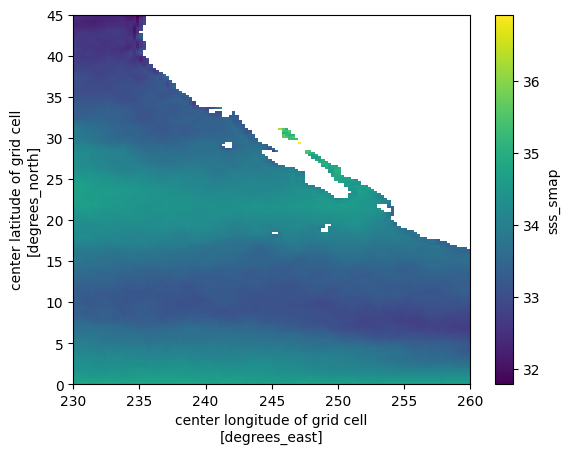

In [47]:
ws_mean_map.plot()